In [81]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten, Dropout, Dense, Conv2D, MaxPool2D

In [14]:
BATCH_SIZE=32
IMAGE_SIZE=256

# make dataset with tf.data.Dataset 

In [16]:
dataset=keras.preprocessing.image_dataset_from_directory(
    "CNN-Tomato-Project",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True,
    seed=100
)

Found 16011 files belonging to 10 classes.


In [21]:
classes=dataset.class_names
classes

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [23]:
for images,labels in dataset.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 256, 256, 3)
[5 4 6 7 7 1 1 2 0 7 1 9 7 1 7 9 5 2 7 0 9 9 3 7 5 7 9 4 0 5 3 1]


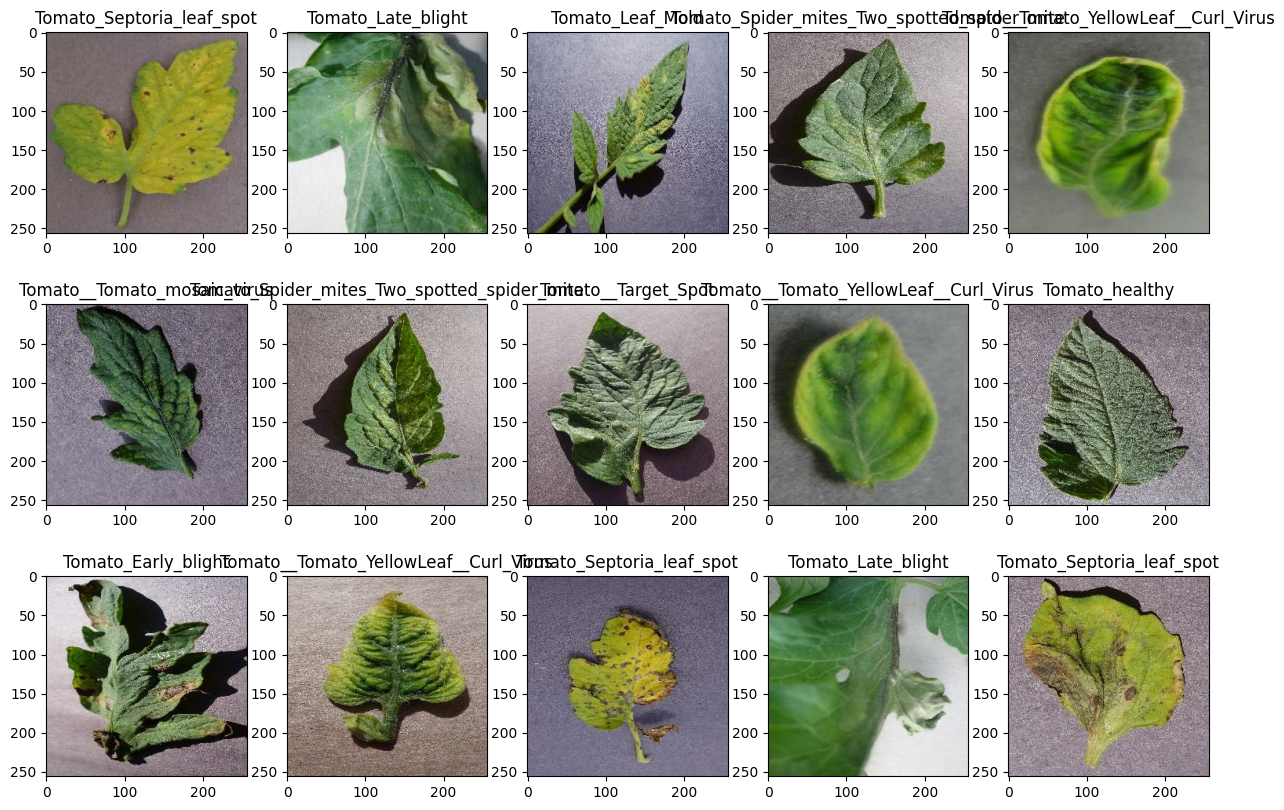

In [38]:
plt.figure(figsize=(15,10))
for images,labels in dataset.take(1):
    for i in range (0,15):
         ax=plt.subplot(3,5,i+1)
         plt.imshow(images[i].numpy().astype("uint8"))
         plt.title(classes[labels[i].numpy()])

# Train-Test Split

In [40]:
shuffle_size = 1000
dataset = dataset.shuffle(shuffle_size, seed=100)
train_ds=dataset.take(int(0.8*len(dataset)))
val_ds=dataset.skip(int(0.8*len(dataset))).take(int(0.1*len(dataset)))
test_ds=dataset.skip(int(0.8*len(dataset))).skip(int(0.1*len(dataset)))

In [43]:
print(f"{len(dataset)}=={len(train_ds)}+{len(val_ds)}+{len(test_ds)}")

501==400+50+51


In [45]:
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(500)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(500)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(500)

# Make CNN Model

In [49]:
Resize_Rescale=keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1/255)
])

In [50]:
data_agumentation=keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomContrast(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

In [55]:
model=keras.Sequential([
    Resize_Rescale,
    data_agumentation,
    ##Conv and Maxscaling layers
    keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    ##Flatten and Dense layer
    keras.layers.Flatten(),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_25 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_25 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [57]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3)

Epoch 1/3
400/400 [==============================] - ETA: 0s - loss: 1.3956 - accuracy: 0.5056

2023-11-19 12:00:38.142939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:64: Filling up shuffle buffer (this may take a while): 296 of 1000
2023-11-19 12:00:47.985105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-11-19 12:00:47.985493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-11-19 12:00:49.927929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:80: Filling up shuffle buffer (this may take a while): 1 of 500
2023-11-19 12:00:50.141662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


400/400 [==============================] - 651s 2s/step - loss: 1.3956 - accuracy: 0.5056 - val_loss: 1.7297 - val_accuracy: 0.4750
Epoch 2/3
400/400 [==============================] - 653s 2s/step - loss: 0.8989 - accuracy: 0.6864 - val_loss: 1.8389 - val_accuracy: 0.4969
Epoch 3/3
400/400 [==============================] - 618s 2s/step - loss: 0.6571 - accuracy: 0.7695 - val_loss: 1.8072 - val_accuracy: 0.5562


# Analyze accuracy and model evaluation

In [58]:
model.evaluate(test_ds)

2023-11-19 12:22:39.517386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:64: Filling up shuffle buffer (this may take a while): 262 of 1000
2023-11-19 12:22:51.321042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:64: Filling up shuffle buffer (this may take a while): 460 of 1000
2023-11-19 12:22:52.934139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-11-19 12:22:52.934576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-11-19 12:22:54.995950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


51/51 [==============================] - 45s 373ms/step - loss: 1.8616 - accuracy: 0.5355


[1.861636757850647, 0.5355392098426819]

In [59]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

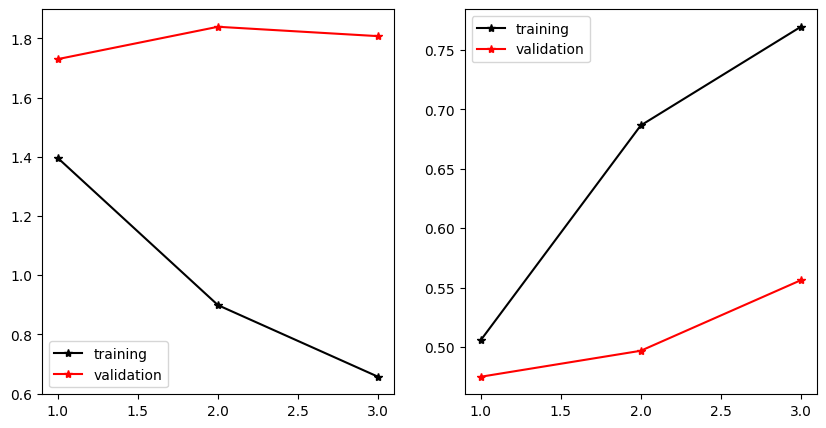

In [73]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.arange(1,4),history.history['loss'],color='black',label='training', marker='*')
plt.plot(np.arange(1,4),history.history['val_loss'],color='red',label='validation', marker='*')
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.arange(1,4),history.history['accuracy'],color='black',label='training', marker='*')
plt.plot(np.arange(1,4),history.history['val_accuracy'],color='red',label='validation', marker='*')
plt.legend()

# Model Prediction

In [76]:
for images,labels in test_ds.take(1):
        ypred=model.predict(images)
        ypred=[np.argmax(i) for i in ypred]
        print(f"predicted labels:{ypred}")
        print(f"actual labels:{labels}")

1/1 [==============================] - 0s 429ms/step
predicted labels:[9, 4, 4, 9, 2, 0, 8, 6, 4, 2, 0, 4, 5, 5, 4, 9, 2, 9, 2, 5, 4, 9, 6, 0, 7, 9, 4, 7, 6, 9, 7, 6]
actual labels:[5 8 4 9 2 0 3 3 3 2 0 3 7 3 4 6 1 5 2 5 3 6 5 0 7 4 3 7 0 5 7 7]


1/1 [==============================] - 0s 410ms/step


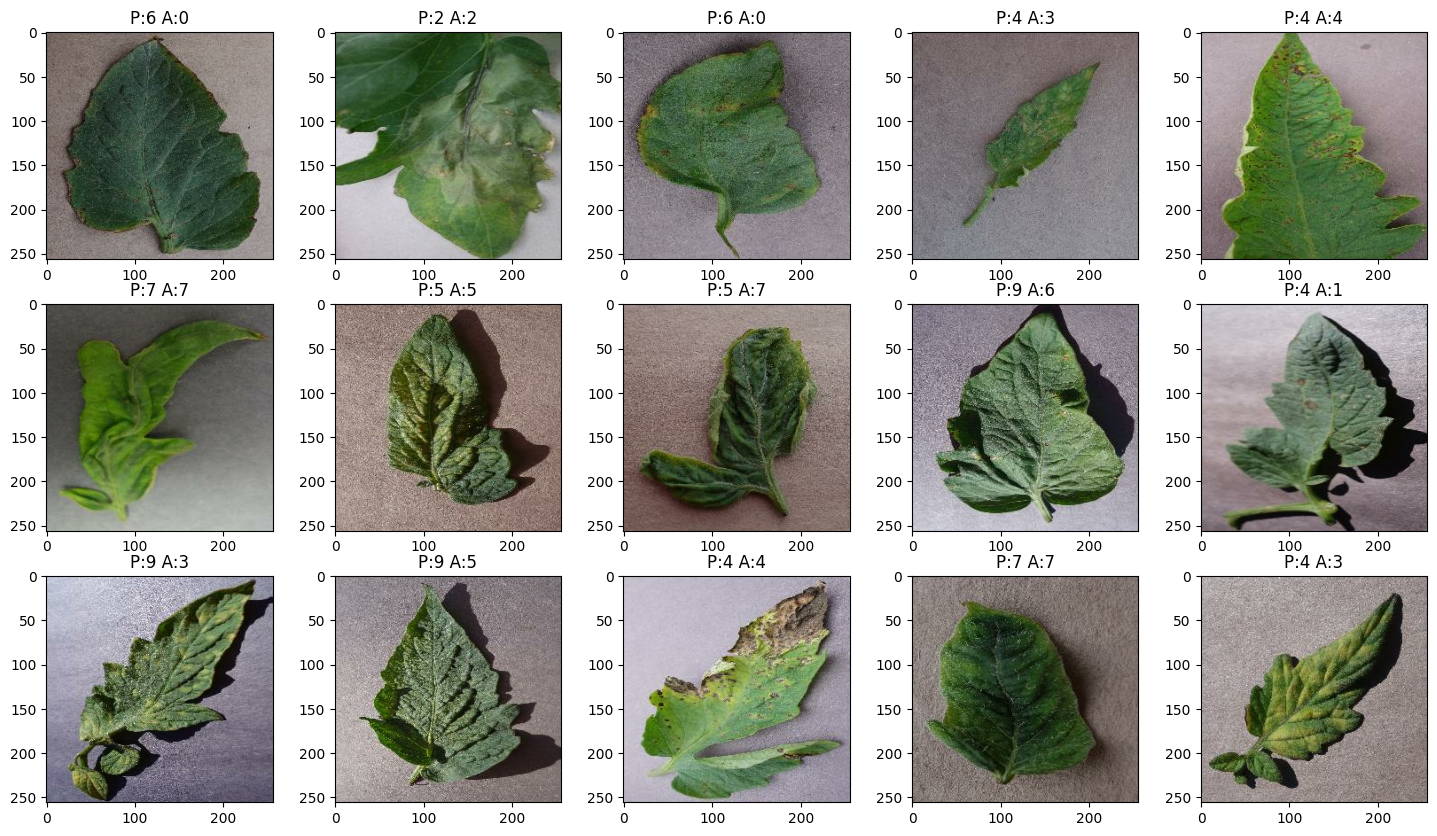

In [80]:
plt.figure(figsize=(18,10))
for images,labels in test_ds.take(1):
    ypred=model.predict(images)
    ypred=[np.argmax(i) for i in ypred]
    for i in range (0,15):
         ax=plt.subplot(3,5,i+1)
         plt.imshow(images[i].numpy().astype("uint8"))
         plt.title(f"P:{ypred[i]} A:{labels[i].numpy()}")        

In [82]:
!mkdir CNN-Tomato-Project/models

In [90]:
model_version=max([int(i) for i in os.listdir("CNN-Tomato-Project/models")]+[0])+1
model.save(f"CNN-Tomato-Project/models/{model_version}")

INFO:tensorflow:Assets written to: CNN-Tomato-Project/models/2/assets


INFO:tensorflow:Assets written to: CNN-Tomato-Project/models/2/assets


In [91]:
!ls -ler CNN-Tomato-Project/models/

total 0
drwxr-xr-x  7 marziehsaeedi  staff  224 Nov 19 12:35 2
drwxr-xr-x  7 marziehsaeedi  staff  224 Nov 19 12:34 1
